In [ ]:
import sys
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json


sys.path.append(str(Path.cwd()))  

from PDP import plot_pdp


In [2]:
def plot_feature_importance(model_type: str, freq: str, method: str = None):
    """
    Plot Feature Importance pour XGBoost ou Régression Linéaire (lasso, ridge).

    Args:
        model_type (str): "xgboost" ou "reg_lin"
        freq (str): "daily" ou "hourly"
        method (str, optional): "lasso" ou "ridge" (uniquement pour reg_lin)
    """
    import joblib
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from pathlib import Path
    import sys

    # === Chemins
    BASE_DIR = Path.cwd().parents[0]
    MODELS_DIR = BASE_DIR / "models"

    # === Charger modèle
    if model_type == "reg_lin":
        if method is None:
            raise ValueError("⚠️ 'method' doit être renseigné pour reg_lin ('lasso' ou 'ridge').")
        model_path = MODELS_DIR / "reg_lin" / f"{method}_classic_{freq}.pkl"
    elif model_type == "xgboost":
        model_path = MODELS_DIR / "xgboost" / f"xgb_{freq}.pkl"
    else:
        raise ValueError("⚠️ Modèle non supporté. Choisir 'xgboost' ou 'reg_lin'.")

    model = joblib.load(model_path)

    # === Charger X
    df = pd.read_csv(BASE_DIR / "data" / "modified_data" / f"test_{freq}.csv")

    sys.path.append(str(BASE_DIR))
    from data_processing.transformation import transform_regression_and_xgb

    df_trans = transform_regression_and_xgb(df, frequency=freq, save=False)
    X = df_trans.drop(columns=["conso_elec_mw", "conso_gaz_mw", "date"], errors="ignore")

    # === Importance
    if model_type == "reg_lin":
        importances = np.abs(model.estimators_[0].coef_)
    elif model_type == "xgboost":
        importances = model.estimators_[0].feature_importances_

    feature_importance = pd.DataFrame({
        "feature": X.columns,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    # === Plot
    plt.figure(figsize=(14, 8))
    sns.barplot(data=feature_importance, x="importance", y="feature", palette="viridis")
    plt.title(f"Feature Importance ({model_type.upper()}) - {freq}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()


***XGBOOST***

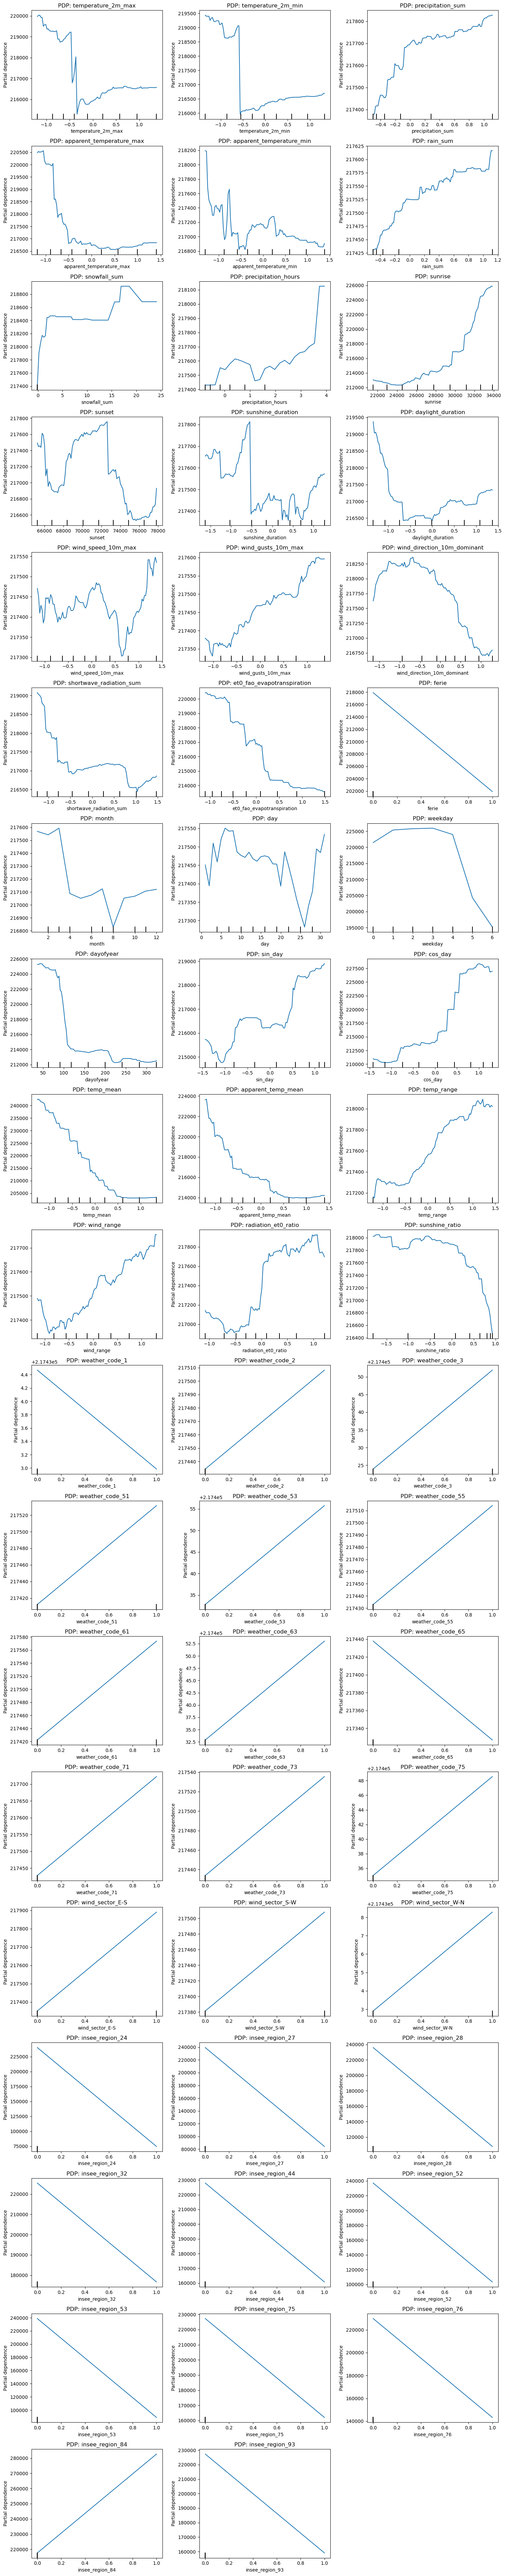

In [3]:
plot_pdp(model_type="xgboost", freq="daily")

C:\Users\arnov\AppData\Local\Temp\ipykernel_10624\479646865.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="importance", y="feature", palette="viridis")


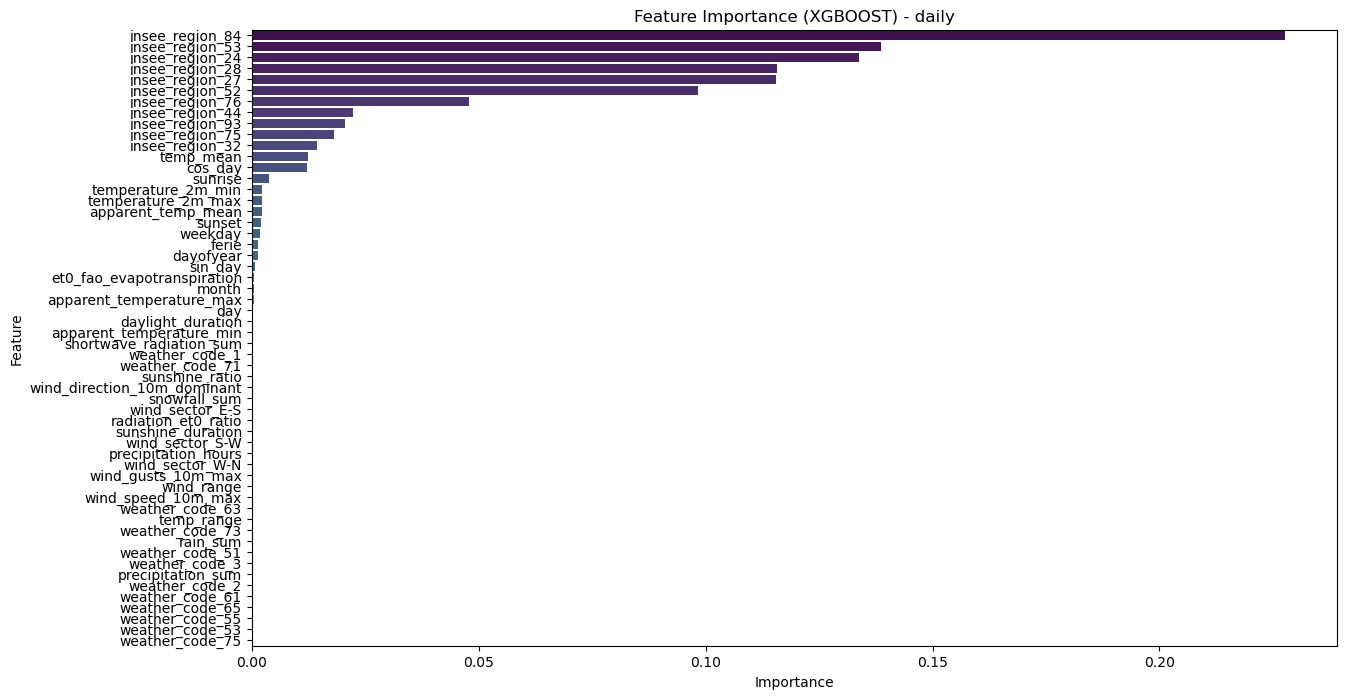

In [4]:
plot_feature_importance(model_type="xgboost", freq="daily")

***Reg Lin ( Ridge )***

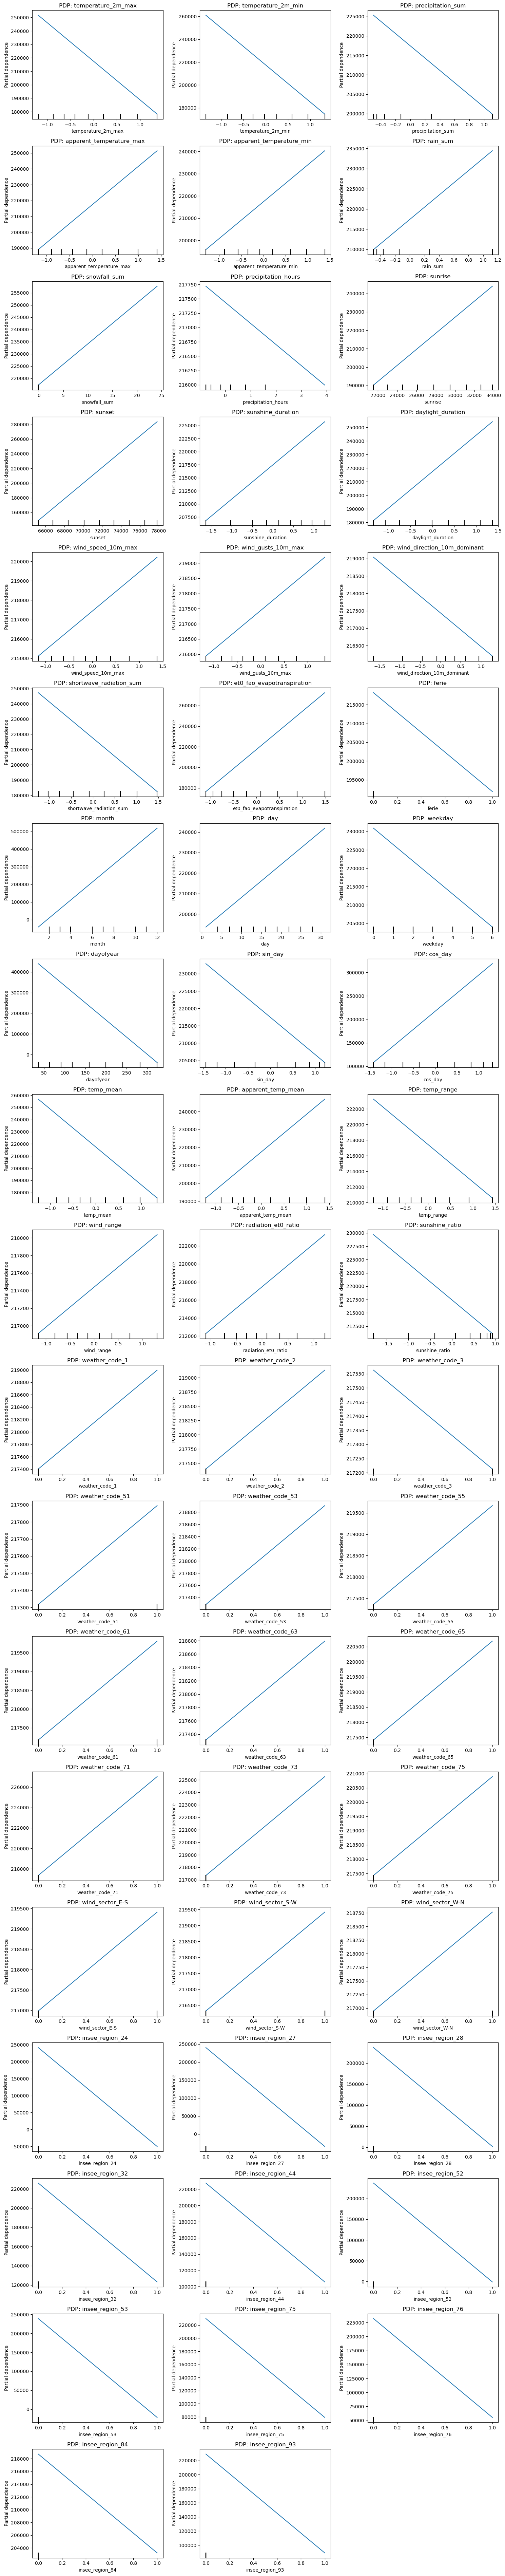

In [5]:
plot_pdp(model_type="reg_lin", freq="daily",method="ridge")

C:\Users\arnov\AppData\Local\Temp\ipykernel_10624\479646865.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="importance", y="feature", palette="viridis")


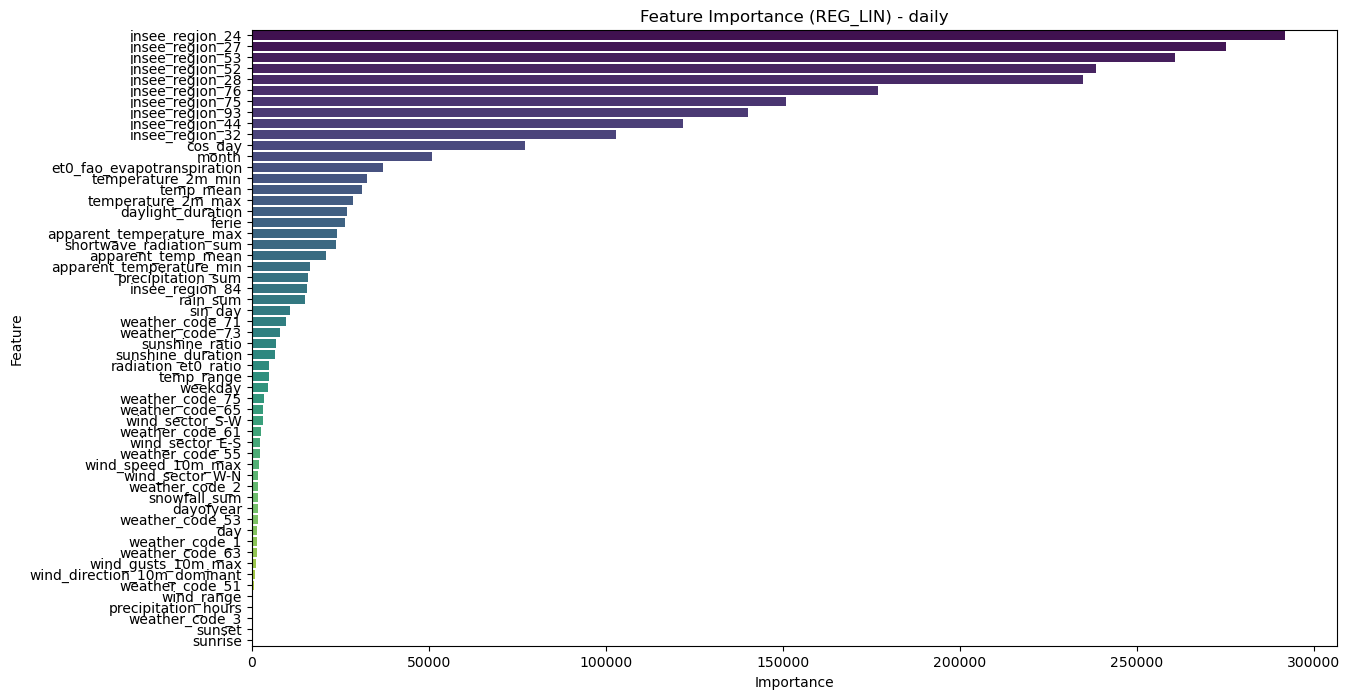

In [6]:
plot_feature_importance(model_type="reg_lin", freq="daily", method="ridge")

***Reg Lin ( Lasso)***

c:\Users\arnov\anaconda3\envs\ML_env\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
c:\Users\arnov\anaconda3\envs\ML_env\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
c:\Users\arnov\anaconda3\envs\ML_env\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
c:\Users\arnov\anaconda3\envs\ML_env\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.s

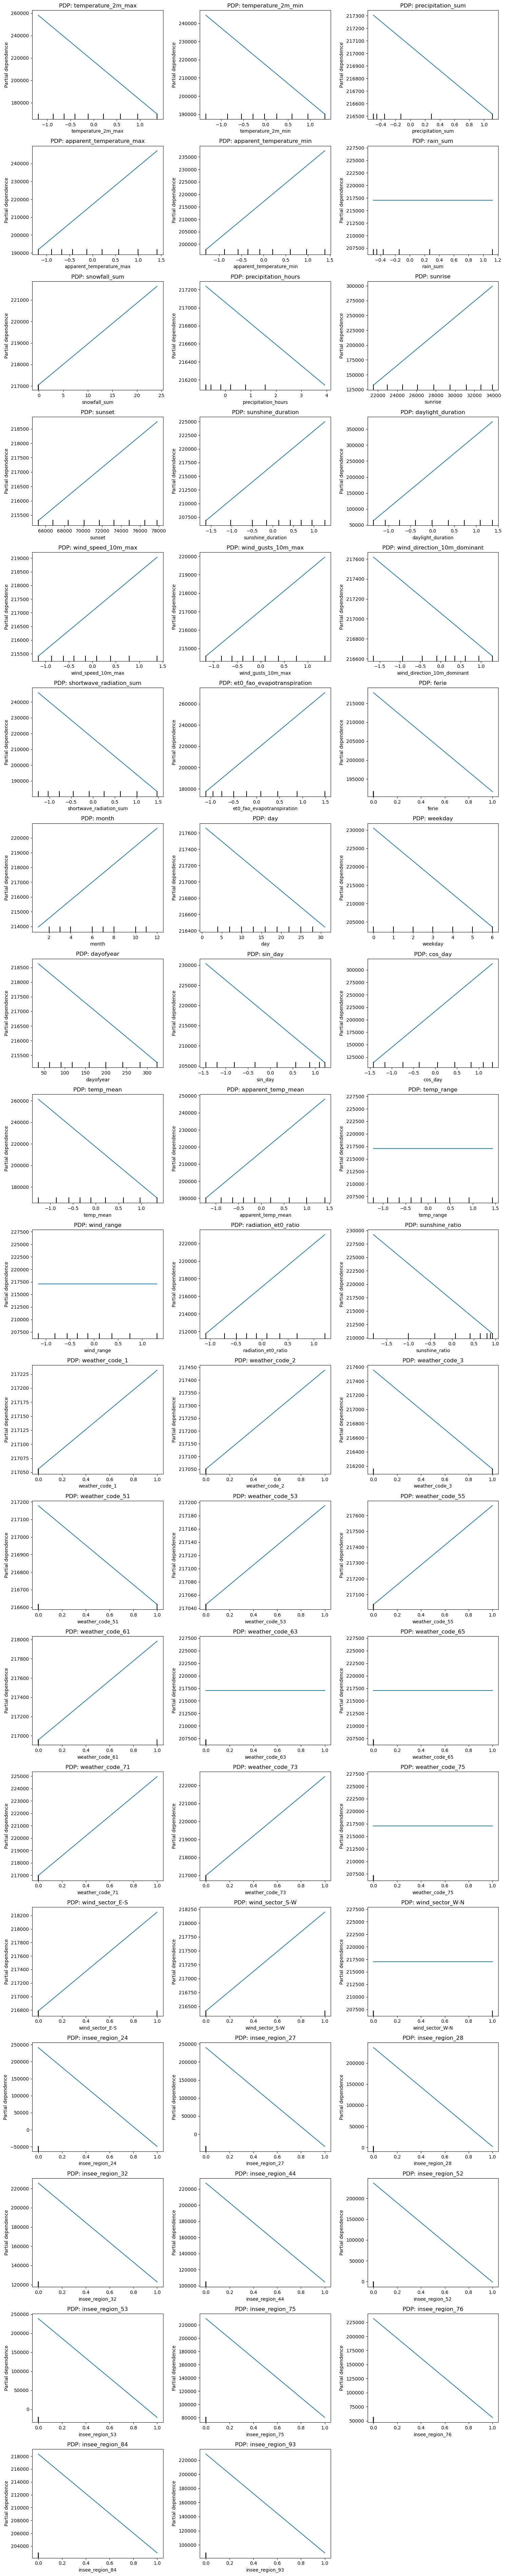

In [7]:
plot_pdp(model_type="reg_lin", freq="daily",method="lasso")

C:\Users\arnov\AppData\Local\Temp\ipykernel_10624\479646865.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="importance", y="feature", palette="viridis")


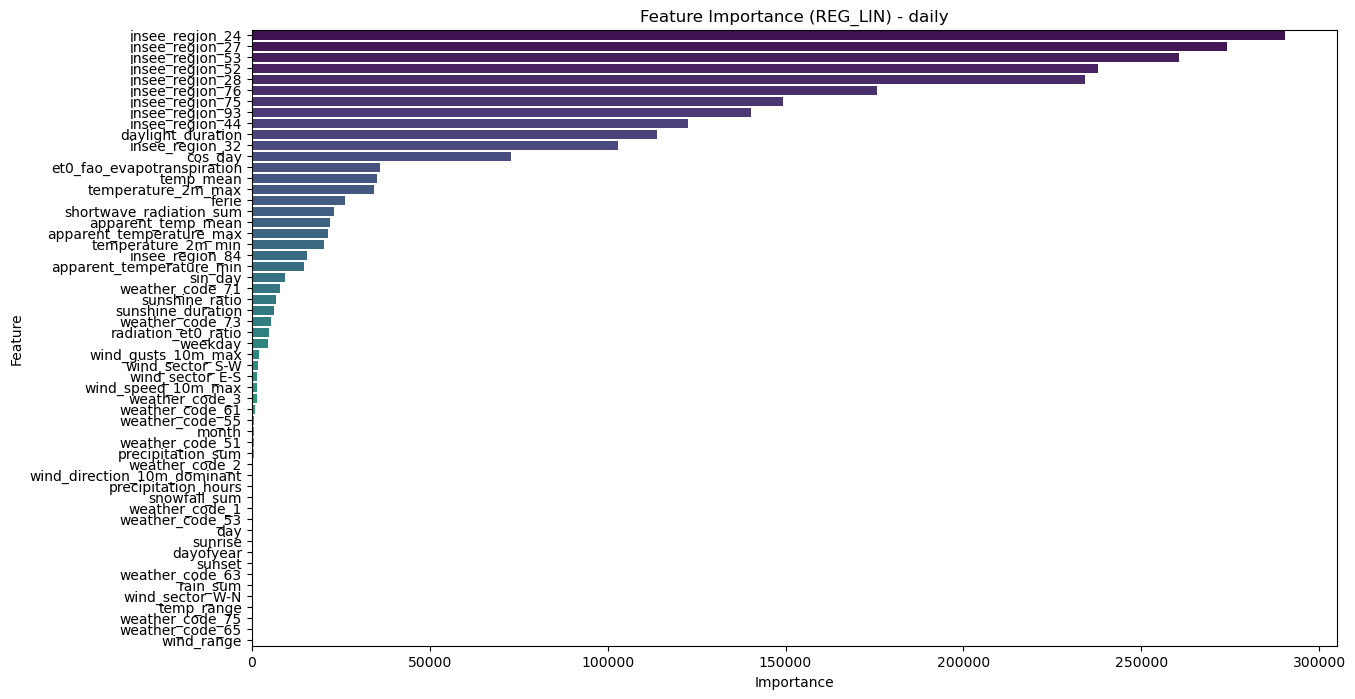

In [8]:
plot_feature_importance(model_type="reg_lin", freq="daily", method="lasso")

***LightGBM quantile(50)***

In [11]:
def plot_feature_importance_lightgbm(freq: str, target: str):
    """
    Affiche l'importance des features pour LightGBM Quantile (q50).
    
    Args:
        freq (str): "daily" ou "hourly"
        target (str): "conso_elec_mw" ou "conso_gaz_mw"
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import joblib
    from pathlib import Path
    import sys

    # === CONFIG ===
    BASE_DIR = Path.cwd().parents[0]
    MODELS_DIR = BASE_DIR / "models" / "Quantile" / "lightgbm_quantile"

    # === Charger modèle LightGBM q50 ===
    model_path = MODELS_DIR / f"{target}_q50_{freq}_withoutlags.pkl"
    if not model_path.exists():
        raise FileNotFoundError(f"Modèle non trouvé : {model_path}")
    model = joblib.load(model_path)

    # === Charger features utilisées ===
    with open(MODELS_DIR / f"features_{freq}_withoutlags.json", "r") as f:
        feature_names = json.load(f)

    # === Récupérer importances
    importances = model.feature_importances_

    feature_importance = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    # === Plot
    plt.figure(figsize=(14, 8))
    sns.barplot(data=feature_importance, x="importance", y="feature", palette="rocket")
    plt.title(f"Feature Importance LightGBM - {target} (q50) - {freq}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()


C:\Users\arnov\AppData\Local\Temp\ipykernel_10624\3004189781.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="importance", y="feature", palette="rocket")


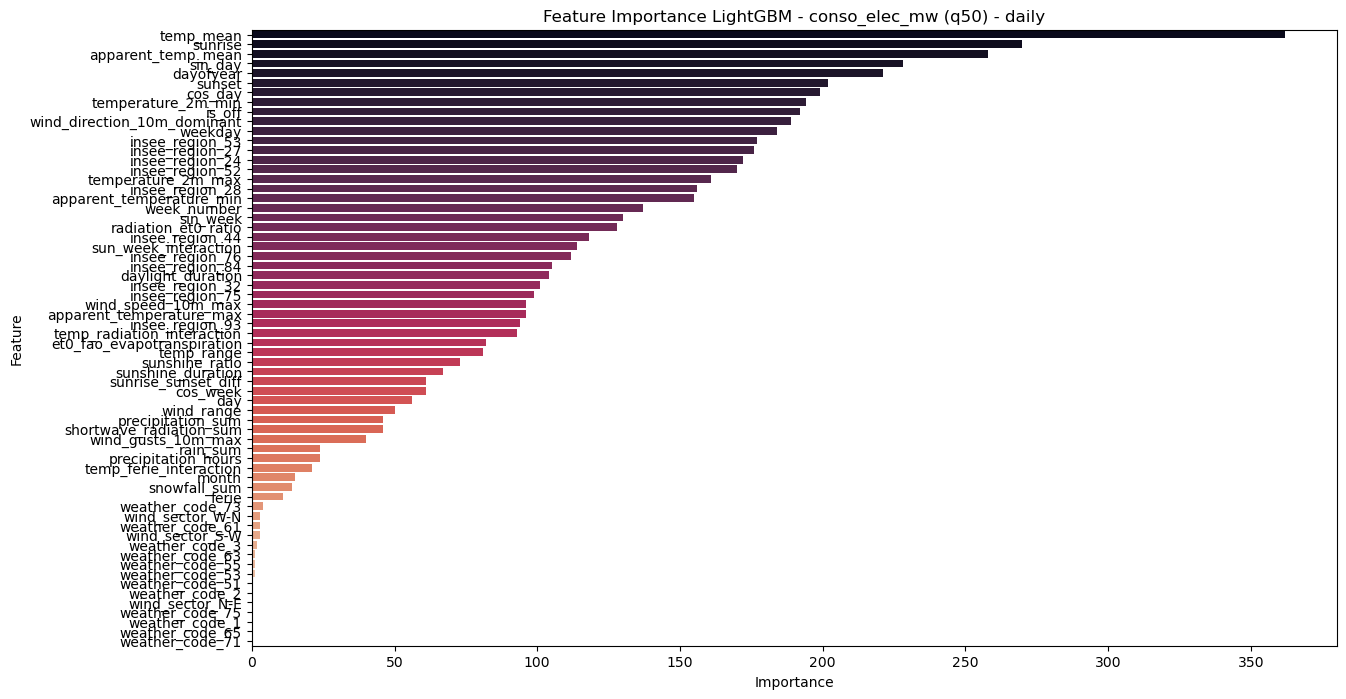

C:\Users\arnov\AppData\Local\Temp\ipykernel_10624\3004189781.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="importance", y="feature", palette="rocket")


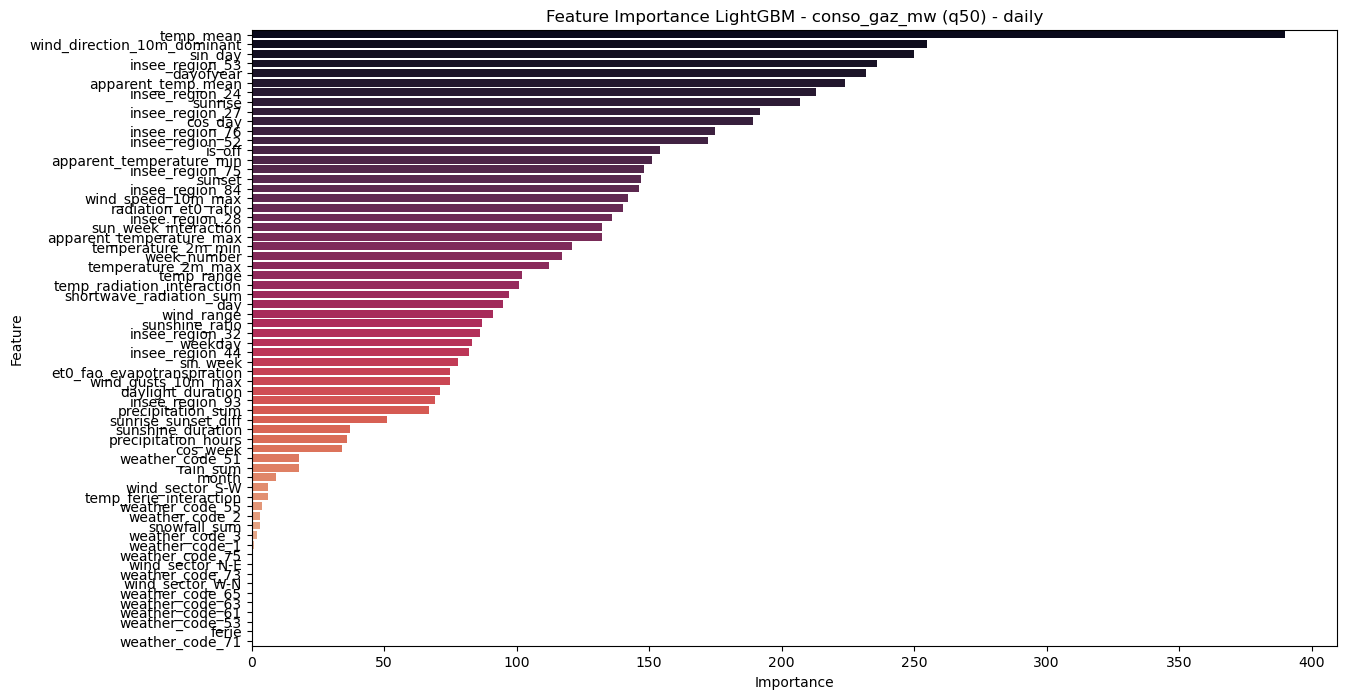

In [12]:
plot_feature_importance_lightgbm(freq="daily", target="conso_elec_mw")

plot_feature_importance_lightgbm(freq="daily", target="conso_gaz_mw")